##### Stock Price Forecasting

In [62]:
# Imports and Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Ensure the results directory exists
if not os.path.exists('../results'):
    os.makedirs('../results')

In [63]:
# Stock Price Forecaster Class

class StockPriceForecaster: # Class to forecast stock price using historical data & ML models
    
    def __init__(self, ticker='WMT', start_date='2021-01-01', end_date=None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date or datetime.now().strftime('%Y-%m-%d')
        self.data = None
        self.features = None
        self.models = {}
        self.predictions = {}
        
    def load_data(self): # Download historical data
        print(f"Downloading {self.ticker} data from {self.start_date} to {self.end_date}...")
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        # Flatten columns
        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)
        print(f"Downloaded {len(self.data)} days of data")
        return self.data
    
    def engineer_features(self): # Create features for prediction
        df = self.data.copy()
        
        # Target variable: Next day's closing price
        df['target'] = df['Close'].shift(-1)
        
        # Lagged Features
        # Previous day prices
        for lag in [1, 2, 3, 5, 7]:
            df[f'close_lag_{lag}'] = df['Close'].shift(lag)
            df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)
            df[f'open_lag_{lag}'] = df['Open'].shift(lag)
            df[f'high_lag_{lag}'] = df['High'].shift(lag)
            df[f'low_lag_{lag}'] = df['Low'].shift(lag)
        
        # Rolling Stats
        # Moving averages
        for window in [7, 14, 30]:
            df[f'ma_{window}'] = df['Close'].shift(1).rolling(window=window).mean()
            df[f'std_{window}'] = df['Close'].shift(1).rolling(window=window).std()
        
        # Price Changes
        df['daily_return'] = df['Close'].pct_change().shift(1)
        df['daily_return_lag_2'] = df['Close'].pct_change().shift(2)
        df['daily_return_lag_3'] = df['Close'].pct_change().shift(3)

        # High-Low range (shifted to avoid data leakage)
        df['high_low_range'] = (df['High'] - df['Low']).shift(1)
        df['high_low_pct'] = ((df['High'] - df['Low']) / df['Close']).shift(1)
        
        # Calendar Features
        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['day_of_month'] = df.index.day
        
        # Indicators
        # RSI (Relative Strength Index)
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi'] = df['rsi'].shift(1)  # Avoid look-ahead bias
        
        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        df['macd'] = df['macd'].shift(1) 

        # Price Momentum
        df['momentum_5'] = df['Close'].shift(1) - df['Close'].shift(6)
        df['momentum_10'] = df['Close'].shift(1) - df['Close'].shift(11)
        
        # Drop rows with NaN values
        df = df.dropna()
        
        self.features = df
        print(f"Created {len(df.columns) - 1} features")
        print(f"Data after feature engineering: {len(df)} rows")
        return df
    
    def prepare_train_test_split(self, test_size=0.2): # Split data into train and test sets
        df = self.features.copy()
        cols_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'target']
        # Separate features and target
        feature_cols = [col for col in df.columns if col not in cols_to_drop]
        print(f"\nAll columns in features: {list(df.columns)}")
        print(f"\nColumns being dropped: {cols_to_drop}")
        print(f"\nFeatures being used: {feature_cols}")
        X = df[feature_cols]
        y = df['target']
        
        # Chrono split
        split_idx = int(len(df) * (1 - test_size))
        
        self.X_train = X.iloc[:split_idx]
        self.X_test = X.iloc[split_idx:]
        self.y_train = y.iloc[:split_idx]
        self.y_test = y.iloc[split_idx:]
        
        print(f"\nTrain set: {len(self.X_train)} days ({self.X_train.index[0]} to {self.X_train.index[-1]})")
        print(f"Test set: {len(self.X_test)} days ({self.X_test.index[0]} to {self.X_test.index[-1]})")
        print(f"\nFeatures being used ({len(feature_cols)} total):")
        print(f"  {', '.join(str(col) for col in feature_cols[:10])}...")
        
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def create_baseline_model(self): # Creating a base model
        # For baseline, we predict that tomorrow = today
        baseline_predictions = self.features['Close'].shift(1).loc[self.y_test.index]
        self.predictions['Baseline'] = baseline_predictions
        
        mae = mean_absolute_error(self.y_test, baseline_predictions)
        rmse = np.sqrt(mean_squared_error(self.y_test, baseline_predictions))
        mape = np.mean(np.abs((self.y_test - baseline_predictions) / self.y_test)) * 100
        
        print("\nBaseline Model")
        print(f"MAE: ${mae:.2f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        
        self.models['Baseline'] = {'mae': mae, 'rmse': rmse, 'mape': mape}
    
    def train_linear_regression(self): # Train Linear Regression model
        print("\nLinear Regression Training")
        
        model = LinearRegression()
        model.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = model.predict(self.X_test)
        self.predictions['Linear Regression'] = pd.Series(y_pred, index=self.y_test.index)
        
        # Eval
        mae = mean_absolute_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mape = np.mean(np.abs((self.y_test - y_pred) / self.y_test)) * 100
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"MAE: ${mae:.2f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        
        self.models['Linear Regression'] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        }
        
        return model
    
    def train_random_forest(self, n_estimators=200): # Train Random Forest model
        print("\nRandom Forest Training")
        
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        model.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = model.predict(self.X_test)
        self.predictions['Random Forest'] = pd.Series(y_pred, index=self.y_test.index)
        
        # Eval
        mae = mean_absolute_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mape = np.mean(np.abs((self.y_test - y_pred) / self.y_test)) * 100
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"MAE: ${mae:.2f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        
        self.models['Random Forest'] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        }
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Important Features:")
        print(feature_importance.head(10))
        
        return model
    
    def train_gradient_boosting(self, n_estimators=100):
        print("\nGradient Boosting Training")
        
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=5,
            min_samples_split=5,
            min_samples_leaf=2,
            learning_rate=0.1,
            random_state=42
        )
        model.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = model.predict(self.X_test)
        self.predictions['Gradient Boosting'] = pd.Series(y_pred, index=self.y_test.index)
        
        # Eval
        mae = mean_absolute_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        mape = np.mean(np.abs((self.y_test - y_pred) / self.y_test)) * 100
        r2 = r2_score(self.y_test, y_pred)
        
        print(f"MAE: ${mae:.2f}")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        
        self.models['Gradient Boosting'] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        }
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Important Features (Gradient Boosting):")
        print(feature_importance.head(10))
    
    def plot_results(self): # Function to plot results
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        #Predictions vs Actual
        ax = axes[0]
        ax.plot(self.y_test.index, self.y_test, label='Actual', linewidth=2, color='black')
        
        colors = ['orange', 'blue', 'green', 'red']
        for (name, pred), color in zip(self.predictions.items(), colors):
            ax.plot(pred.index, pred, label=name, alpha=0.7, linewidth=1.5, color=color)
        
        ax.set_title(f'{self.ticker} Stock Price Predictions', fontsize=16, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price ($)', fontsize=12)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Model Comparison
        ax = axes[1]
        metrics_df = pd.DataFrame({
            'Model': list(self.models.keys()),
            'MAE': [self.models[m]['mae'] for m in self.models.keys()],
            'RMSE': [self.models[m]['rmse'] for m in self.models.keys()],
        })
        
        x = np.arange(len(metrics_df))
        width = 0.35
        
        ax.bar(x - width/2, metrics_df['MAE'], width, label='MAE', alpha=0.8)
        ax.bar(x + width/2, metrics_df['RMSE'], width, label='RMSE', alpha=0.8)
        
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Error ($)', fontsize=12)
        ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_df['Model'])
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('results/stock_forecast_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_summary(self): # Function to print summary of results
        print(f"STOCK PRICE FORECASTING SUMMARY - {self.ticker}")
        
        print(f"\nData Period: {self.start_date} to {self.end_date}")
        print(f"Total Days: {len(self.features)}")
        print(f"Training Days: {len(self.X_train)}")
        print(f"Testing Days: {len(self.X_test)}")
        
        print("\nMODEL PERFORMANCE COMPARISON")
        print(f"{'Model':<25} {'MAE':>10} {'RMSE':>10} {'MAPE':>10}")
        
        for model_name in self.models.keys():
            mae = self.models[model_name]['mae']
            rmse = self.models[model_name]['rmse']
            mape = self.models[model_name]['mape']
            print(f"{model_name:<25} ${mae:>9.2f} ${rmse:>9.2f} {mape:>9.2f}%")
        
        
        # Finding best model
        best_model = min(self.models.items(), key=lambda x: x[1]['mae'])
        print(f"\n Best Model (by MAE): {best_model[0]}")
        print(f"   MAE: ${best_model[1]['mae']:.2f}")
        print(f"   RMSE: ${best_model[1]['rmse']:.2f}")
        print(f"   MAPE: {best_model[1]['mape']:.2f}%")
        
        # Calculating improvement over baseline
        if 'Baseline' in self.models and best_model[0] != 'Baseline':
            baseline_mae = self.models['Baseline']['mae']
            improvement = ((baseline_mae - best_model[1]['mae']) / baseline_mae) * 100
            print(f"\n   Improvement over Baseline: {improvement:.2f}%")
        


[*********************100%***********************]  1 of 1 completed

STOCK PRICE FORECASTING MINI PROJECT
Downloaded 1280 days of data
Created 49 features
Data after feature engineering: 1249 rows

All columns in features: ['Close', 'High', 'Low', 'Open', 'Volume', 'target', 'close_lag_1', 'volume_lag_1', 'open_lag_1', 'high_lag_1', 'low_lag_1', 'close_lag_2', 'volume_lag_2', 'open_lag_2', 'high_lag_2', 'low_lag_2', 'close_lag_3', 'volume_lag_3', 'open_lag_3', 'high_lag_3', 'low_lag_3', 'close_lag_5', 'volume_lag_5', 'open_lag_5', 'high_lag_5', 'low_lag_5', 'close_lag_7', 'volume_lag_7', 'open_lag_7', 'high_lag_7', 'low_lag_7', 'ma_7', 'std_7', 'ma_14', 'std_14', 'ma_30', 'std_30', 'daily_return', 'daily_return_lag_2', 'daily_return_lag_3', 'high_low_range', 'high_low_pct', 'day_of_week', 'month', 'quarter', 'day_of_month', 'rsi', 'macd', 'momentum_5', 'momentum_10']

Columns being dropped: ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'target']

Features being used: ['close_lag_1', 'volume_lag_1', 'open_lag_1', 'high_lag_1', 'low_lag_1', 'clo

MAE: $5.37
RMSE: $8.06
MAPE: 4.98%
R²: 0.2459

Top 10 Important Features:
        feature  importance
2    open_lag_1    0.094419
9     low_lag_2    0.080555
8    high_lag_2    0.079566
0   close_lag_1    0.076286
4     low_lag_1    0.076092
3    high_lag_1    0.066783
5   close_lag_2    0.066689
7    open_lag_2    0.061619
13   high_lag_3    0.051790
14    low_lag_3    0.046256

Gradient Boosting Training
MAE: $5.22
RMSE: $7.88
MAPE: 4.83%
R²: 0.2800

Top 10 Important Features (Gradient Boosting):
        feature  importance
0   close_lag_1    0.324300
7    open_lag_2    0.188215
4     low_lag_1    0.125346
3    high_lag_1    0.096413
13   high_lag_3    0.059778
29        ma_30    0.050726
9     low_lag_2    0.043481
2    open_lag_1    0.039773
8    high_lag_2    0.027067
27        ma_14    0.013057


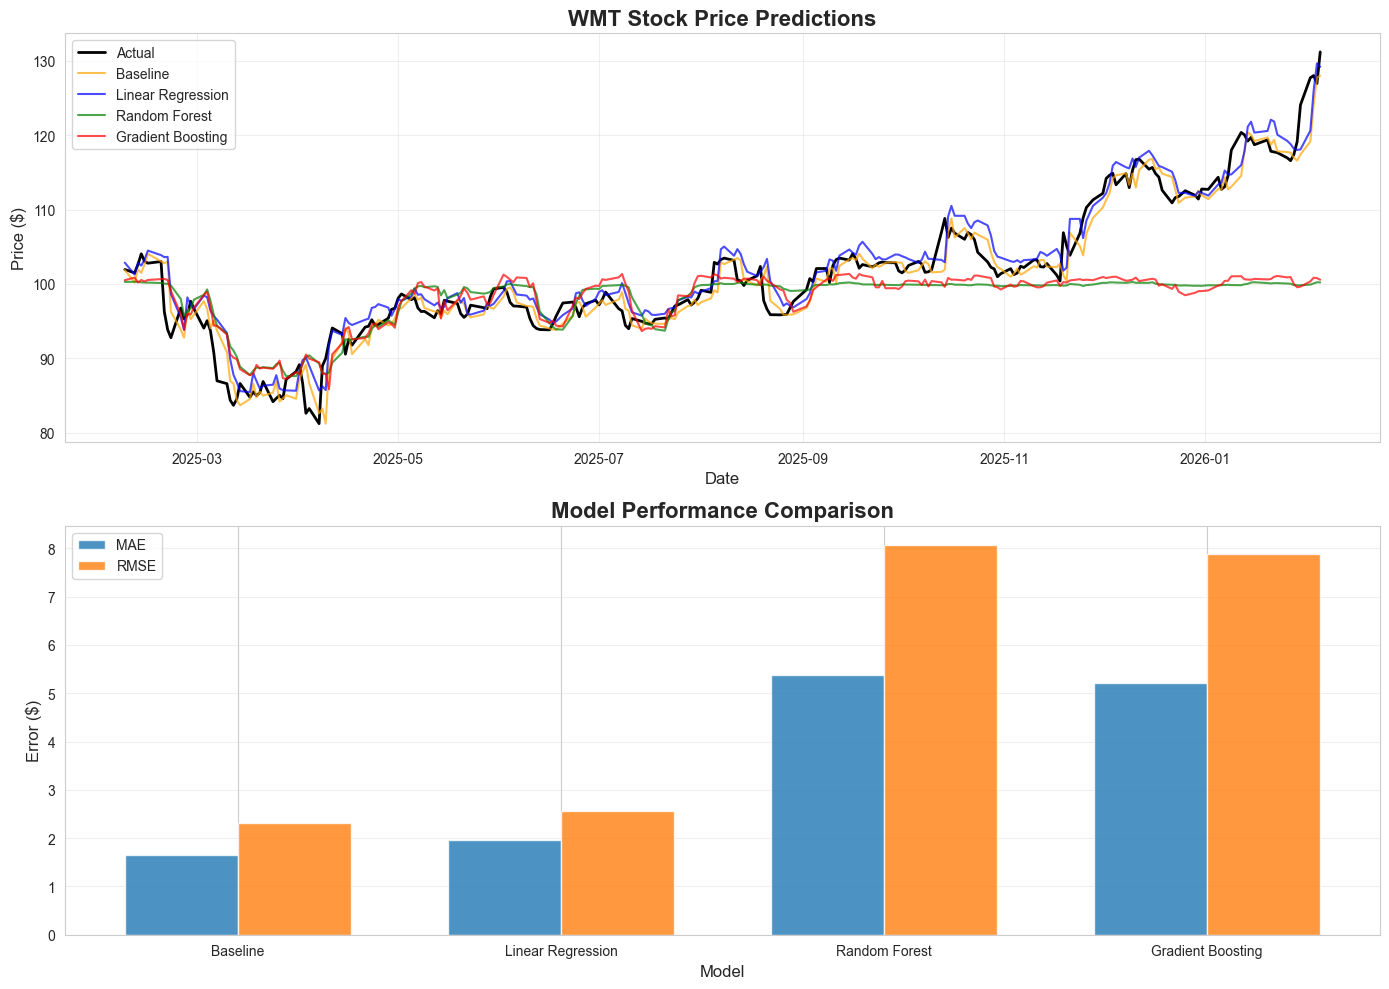

STOCK PRICE FORECASTING SUMMARY - WMT

Data Period: 2021-01-01 to 2026-02-07
Total Days: 1249
Training Days: 999
Testing Days: 250

MODEL PERFORMANCE COMPARISON
Model                            MAE       RMSE       MAPE
Baseline                  $     1.65 $     2.32      1.64%
Linear Regression         $     1.96 $     2.56      1.97%
Random Forest             $     5.37 $     8.06      4.98%
Gradient Boosting         $     5.22 $     7.88      4.83%

 Best Model (by MAE): Baseline
   MAE: $1.65
   RMSE: $2.32
   MAPE: 1.64%

✅ Prediction Complete!


In [64]:
# Main Function to Run the prediction

def main():
    print("="*70)
    print("STOCK PRICE FORECASTING MINI PROJECT")
    print("="*70)
    
    # Initialize forecaster
    forecaster = StockPriceForecaster(
        ticker='WMT',  # Can Change to any stock.
        start_date='2021-01-01',
        end_date=None  # None = today
    )
    
    # Load Data
    forecaster.load_data()
    
    # Feature Engg
    forecaster.engineer_features()
    
    # Train/test split (80/20)
    forecaster.prepare_train_test_split(test_size=0.2)
    
    # Baseline model
    forecaster.create_baseline_model()
    
    # Train Linear Regression
    forecaster.train_linear_regression()
    
    # Train Random Forest
    forecaster.train_random_forest(n_estimators=200)

    # Train Gradient Boosting
    forecaster.train_gradient_boosting(n_estimators=100)
    
    #Visualize results
    forecaster.plot_results()
    
    #Print summary
    forecaster.print_summary()
    
    print("\n✅ Prediction Complete!")

if __name__ == "__main__":
    main()

